In [1]:
EXP_NAME = 'LUCAS_Transformer_NoImage'

In [2]:
from train_utils import *
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import random
import numpy as np
from dataset.utils.utils import TextColors as tc
from plot_utils.plot import plot_train_test_losses
from datetime import date, datetime
import torch.nn.functional as F
import cv2
import json
import warnings

In [3]:
DATASET = 'LUCAS' # 'LUCAS', 'RaCA'

if DATASET == 'LUCAS':
    from dataset.dataset_loader import SNDataset,SNDatasetClimate, myNormalize, myToTensor, Augmentations
    OC_MAX = 87
    # OC_MAX = 560.2
if DATASET == 'RaCA':
    from dataset.dataset_loader_us import SNDataset,SNDatasetClimate, myNormalize, myToTensor, Augmentations
    OC_MAX = 4115

In [4]:
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

In [5]:
# Format the date and time
now = datetime.now()
start_string = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Date and Time:", start_string)

Current Date and Time: 2024-03-26 11:42:36


In [6]:
import os
os.getcwd()

NAFISEH = "Nafiseh"
MOIEN = "Moien"

if "d:" in os.getcwd():
    USER = MOIEN
elif "c:" in os.getcwd():
    USER = NAFISEH
else:
    raise Exception("Unknown user")

USER

'Nafiseh'

In [7]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
# CONFIG
NUM_WORKERS = 6 if USER == NAFISEH else 2
TRAIN_BATCH_SIZE = 32 if USER == NAFISEH else 4
TEST_BATCH_SIZE = 32 if USER == NAFISEH else 4
LEARNING_RATE = 1e-4 if USER == NAFISEH else 1e-3
NUM_EPOCHS = 20 if USER == NAFISEH else 2
LR_SCHEDULER = "step" # step, plateau or None

USE_SRTM = True

USE_SPATIAL_ATTENTION = False if USER == NAFISEH else False

CNN_ARCHITECTURE = "ViT" # vgg16 or resnet101 or "ViT" or resnet50
RNN_ARCHITECTURE = 'Transformer' # LSTM, GRU, RNN, Transformer
REG_VERSION = 1 if USER == NAFISEH else 1

USE_LSTM_BRANCH = True

if USE_LSTM_BRANCH == True:
   
   USE_PRIM_CLIM = True
   USE_SEC_CLIM = True

else:
  USE_PRIM_CLIM = False
  USE_SEC_CLIM = False

#%%%%%%%%%%%%%%%%%%%%%%%%%% Using Only Climate Data %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

JUST_LSTM = True # Using Only Climate Data

if JUST_LSTM:
    USE_LSTM_BRANCH = True
    USE_SPATIAL_ATTENTION = False

LOG_LOSS = True
SAVE_TRAIN_DATA_METRICS = True

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%% SSl Section %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

LOAD_SIMCLR_MODEL = False


if DATASET == 'LUCAS':
  # SIMCLR_PATH = "C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\results\\RUN_LUCAS_Self_ViT_trans_D_2024_02_26_T_13_35_Nafiseh_SelfSupervised.pth"
  # SIMCLR_PATH = "C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\results\\RUN_LUCAS_Self_ViT_LSTM_D_2024_02_27_T_11_21_Nafiseh_SelfSupervised.pth"
  SIMCLR_PATH = "C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\results\\RUN_LUCAS_Self_CNN_Trans_D_2024_02_29_T_18_02_Nafiseh_SelfSupervised.pth"

 
  
  #Large samples for LUCAS: Saved on 27.02.2024

if DATASET == 'RaCA':
  # SIMCLR_PATH = "C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\results\\RUN_RaCA_Self_D_2024_02_08_T_12_00_Nafiseh_SelfSupervised.pth"
  # SIMCLR_PATH = "C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\results\\RUN_RaCA_Self_LSTM_D_2024_02_13_T_18_14_Nafiseh_SelfSupervised.pth"
  SIMCLR_PATH = "C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\results\\RUN_RaCA_Self_CNN_trans_D_2024_02_14_T_12_14_Nafiseh_SelfSupervised.pth"
  

if LOAD_SIMCLR_MODEL:
    if USE_LSTM_BRANCH == False:
        raise Exception("LOAD_SIMCLR_MODEL is enabled but LSTM branch is disabled. Please enable LSTM branch.")
    if JUST_LSTM:
        raise Exception("LOAD_SIMCLR_MODEL is enabled but JUST_LSTM is enabled. Please disable JUST_LSTM.")

if LOAD_SIMCLR_MODEL:
    print("\033[91m\033[1m\033[5mWARNING!\033[0m")
    print("\033[93m Loading SimCLR Model is enabled.\
        \n This will overwrite Chosen Architectures\
        \n Also, make sure that LSTM is enabled. \033[0m")    

In [9]:

if USE_SRTM:
    mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)], [(12), (-4,2963)], [(13), (0, 90)]], oc_min = 0, oc_max = OC_MAX)
else:
    mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)]], oc_min = 0, oc_max = OC_MAX)
    
my_to_tensor = myToTensor()
my_augmentation = Augmentations()
train_transform = transforms.Compose([mynorm, my_to_tensor,my_augmentation])
test_transform = transforms.Compose([mynorm, my_to_tensor])

In [10]:
if USER == MOIEN:
    train_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\train\\'
    test_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\test\\'
    val_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\val\\'
    testval_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\val\\'
    lucas_csv_path = 'D:\python\SoilNet\dataset\LUCAS_2015_all.csv'
    climate_csv_folder_path = "D:\\python\\SoilNet\\dataset\\Climate\\All\\filled\\"
    
elif USER == NAFISEH:

    if DATASET == 'LUCAS':
     train_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\l8_images\\train'
     test_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\l8_images\\test'
     val_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\l8_images\\val'
     testval_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\l8_images\\test_val'
     lucas_csv_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\LUCAS_2015_all.csv'
     climate_csv_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\Climate\\All\\filled'

    if DATASET == 'RaCA':
     train_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images_us\\train'
     test_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images_us\\test'
     val_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images_us\\val'
     testval_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images_us\\test_val'
     lucas_csv_path = "C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\RapidCarbon_OC.csv"
     climate_csv_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\Climate\\RaCA\\filled'

     if USE_LSTM_BRANCH: 

        if USE_PRIM_CLIM and not USE_SEC_CLIM:
           climate_csv_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\Climate\\RaCA\\filled\\PrimClim'

        if USE_SEC_CLIM and not USE_PRIM_CLIM:
           climate_csv_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\Climate\\RaCA\\filled\\SecClim'

        if USE_SEC_CLIM and USE_PRIM_CLIM:
           climate_csv_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\Climate\\RaCA\\filled'

In [11]:
bands = [0,1,2,3,4,5,6,7,8,9,10,11] if not USE_SRTM else [0,1,2,3,4,5,6,7,8,9,10,11,12,13]


################################# IF Not USE_LSTM_BRANCH ###############################
if not USE_LSTM_BRANCH: # NOT USING THE CLIMATE DATA

    train_ds = SNDataset(train_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=train_transform)
    test_ds =  SNDataset(test_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform)
    val_ds = SNDataset(val_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform)
    test_ds_w_id =  SNDataset(test_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform, return_point_id=True)
    testval_ds_w_id =  SNDataset(testval_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform, return_point_id=True)
    
################################### IF USE_LSTM_BRANCH #################################
else: # USING THE CLIMATE DATA
    train_ds = SNDatasetClimate(train_l8_folder_path,
                                    lucas_csv_path,
                                    climate_csv_folder_path,
                                    l8_bands=bands, transform=train_transform)

    test_ds = SNDatasetClimate(test_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform)
    
    val_ds = SNDatasetClimate(val_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform)
    
    test_ds_w_id = SNDatasetClimate(test_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform, return_point_id=True)

    testval_ds_w_id = SNDatasetClimate(testval_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform, return_point_id=True)
    


In [12]:
SEQ_LEN = testval_ds_w_id[0][0][1].shape[0]
SEQ_LEN # max sequence length for Transformer model set up

61

In [13]:
# COUNTING the csv files in the csv folder
CSV_FILES = [f for f in os.listdir(climate_csv_folder_path) if f.endswith('.csv')]
NUM_CLIMATE_FEATURES = len(CSV_FILES)
NUM_CLIMATE_FEATURES

11

In [14]:
from soilnet.soil_net import SoilNet, SoilNetLSTM, SoilNetSimCLRwRegHead, SoilNetJustLSTM

__name__: submodules.src.transformer.transformer


In [15]:
# train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
# # Get image and label from custom DataLoader
# img_custom, climate,label_custom = next(iter(train_dl))
# print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
# print(f"Climate shape: {climate.shape} -> [batch_size, climate_channels]")
# print(f"Label shape: {label_custom.shape}")
# img_gpu = img_custom.to(device)
# print(img_gpu.device, img_gpu.shape)
# print(img_gpu.shape)
# y = model(img_gpu)
# y.detach()

In [16]:
cv_results = {"train_loss": [],
               "val_loss": [],
               "MAE": [],
               "RMSE": [],
               "R2": [],
               "train_MAE": [],
                "train_RMSE": [],
                "train_R2": []
    }

In [17]:
from datetime import date, datetime
# Format the date and time
now = datetime.now()
run_name = now.strftime("D_%Y_%m_%d_T_%H_%M")
print("Current Date and Time:", run_name)
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

Current Date and Time: D_2024_03_26_T_11_42


In [18]:
SEEDS = [1, 4] 
# SEEDS = [75]
# SEEDS = [1] if USER == MOIEN else [1, 4, 69, 75, 79, 128, 474, 786, 2048, 3333]

In [19]:
# from skimage import io
# import os

# folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images_us\\train'

# # Iterate over files in the folder
# for filename in os.listdir(folder_path):
#     # Construct the full path to each image file
#     file_path = os.path.join(folder_path, filename)

#     try:
#         # Load the image
#         l8_img = io.imread(file_path)
#         # Process the loaded image or perform any other operations
#     except Exception as e:
#         print(f"Error loading image {file_path}: {e}")
#         # Handle the error or skip the file if necessary


In [20]:
best_mae = 1000 # just a big number, since our data is normalized between 0 and 1, mae is between 0 and 1 too.
worst_mae = 0 # just a small number, since our data is normalized between 0 and 1, mae is between 0 and 1 too.

best_rmse = 1000 # just a big number, since our data is normalized between 0 and 1, rmse is between 0 and 1 too.
worst_rmse = 0 # just a small number, since our data is normalized between 0 and 1, rmse is between 0 and 1 too.

best_seed = SEEDS[0]
worst_seed = SEEDS[0]

for idx, seed in enumerate(SEEDS):
    print(tc.BOLD_BAKGROUNDs.PURPLE, f"CROSS VAL {idx+1}", tc.ENDC)
    
    
    train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    test_dl = DataLoader(test_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    val_dl = DataLoader(val_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    #model = SoilNetFC(cnn_in_channels=12, regresor_input_from_cnn=1024, hidden_size=128).to(device)
    architecture = "101+GLAM" if USE_SPATIAL_ATTENTION else "101"
    if not JUST_LSTM:
       if USE_LSTM_BRANCH:
            model = SoilNetLSTM(use_glam=USE_SPATIAL_ATTENTION, cnn_arch= CNN_ARCHITECTURE, reg_version= REG_VERSION,
                           cnn_in_channels=len(bands), regresor_input_from_cnn=1024,
                           lstm_n_features= NUM_CLIMATE_FEATURES, lstm_n_layers= 2, lstm_out= 128,
                           hidden_size=128, rnn_arch=RNN_ARCHITECTURE,seq_len=SEQ_LEN).to(device)
       else:
            model = SoilNet(use_glam=USE_SPATIAL_ATTENTION, cnn_arch = CNN_ARCHITECTURE, reg_version= REG_VERSION,
                       cnn_in_channels=len(bands), regresor_input_from_cnn=1024, hidden_size=128).to(device)
            
    else:
        model = SoilNetJustLSTM(use_glam=USE_SPATIAL_ATTENTION, cnn_arch= CNN_ARCHITECTURE, reg_version= REG_VERSION,
                            cnn_in_channels=len(bands), regresor_input_from_cnn=1024,
                            lstm_n_features= NUM_CLIMATE_FEATURES, lstm_n_layers= 2, lstm_out= 128,
                            hidden_size=128, rnn_arch=RNN_ARCHITECTURE,seq_len=SEQ_LEN).to(device)
    
    if LOAD_SIMCLR_MODEL:
        model = torch.load(SIMCLR_PATH).to(device)
        model = SoilNetSimCLRwRegHead(model, hidden_size=128, reg_version=REG_VERSION).to(device)
        
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Saving the model on the last epoch
    # save_model_path = f"results/RUN_{EXP_NAME}_{run_name}_{USER}_best.pth.tar"
    save_model_path = None

    
    loss_instance = RMSLELoss() if LOG_LOSS else RMSELoss()
        
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    results = train(model, train_dl, test_dl, val_dl,
                    optimizer,
                    loss_instance, epochs=NUM_EPOCHS, lr_scheduler=LR_SCHEDULER,
                    save_model_path= save_model_path,
                    save_model_if_mae_lower_than= best_rmse,
                    save_train_data_metrics=SAVE_TRAIN_DATA_METRICS
                    )

    
    cv_results['train_loss'].append(results['train_loss'])
    cv_results['val_loss'].append(results['val_loss'])
    cv_results['MAE'].append(results['MAE'][0])
    cv_results['RMSE'].append(results['RMSE'][0])
    cv_results['R2'].append(results['R2'][0])
    
    if SAVE_TRAIN_DATA_METRICS:
        cv_results['train_MAE'].append(results['train_MAE'])
        cv_results['train_RMSE'].append(results['train_RMSE'])
        cv_results['train_R2'].append(results['train_R2'])
    
    # Stop the training loop via RMSE 
    if results['RMSE'][0] < best_rmse:
        best_rmse = results['RMSE'][0]
        best_seed = seed
        print(tc.BOLD_BAKGROUNDs.GREEN, f"Best RMSE improved to {best_rmse}", tc.ENDC)
        # Save the best model
        best_model_path = f"results/RUN_{EXP_NAME}_{run_name}_{USER}_best.pth.tar"
        save_checkpoint(model, optimizer=optimizer, filename=best_model_path)
        
    if results['RMSE'][0] > worst_rmse:
        worst_rmse = results['RMSE'][0]
        worst_seed = seed
        print(tc.BOLD_BAKGROUNDs.RED, f"Worst RMSE worsened to {worst_rmse}", tc.ENDC)
        # Save the worst model
        worst_model_path = f"results/RUN_{EXP_NAME}_{run_name}_{USER}_worst.pth.tar"
        save_checkpoint(model, optimizer=optimizer, filename=worst_model_path)
        
    print(f"This Runs RMSE: {results['RMSE'][0]}")


    # Stop the training loop via MAE
    # if results['MAE'][0] < best_mae:
    #     best_mae = results['MAE'][0]
    #     best_seed = seed
    #     print(tc.BOLD_BAKGROUNDs.GREEN, f"Best MAE improved to {best_mae}", tc.ENDC)
    
    # if results['MAE'][0] > worst_mae:
    #     worst_mae = results['MAE'][0]
    #     worst_seed = seed
    #     print(tc.BOLD_BAKGROUNDs.RED, f"Worst MAE worsened to {worst_mae}", tc.ENDC)
    #     # Save the worst model
    #     worst_model_path = f"results/RUN_{EXP_NAME}_{run_name}_{USER}_worst.pth.tar"
    #     save_checkpoint(model, optimizer=optimizer, filename=worst_model_path)
        
    # print(f"This Runs MAE: {results['MAE'][0]}")

 CROSS VAL 1 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 478/478 [00:41<00:00, 11.63it/s, Train_Loss=0.159]


 Epoch 1 Results: |  train_loss: 0.15851419370730552 |  val_loss: 0.1577561144595561  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 478/478 [00:39<00:00, 12.17it/s, Train_Loss=0.154]


 Epoch 2 Results: |  train_loss: 0.1543790446633325 |  val_loss: 0.1521097051816574  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 478/478 [00:39<00:00, 12.06it/s, Train_Loss=0.152]


 Epoch 3 Results: |  train_loss: 0.1515681113595743 |  val_loss: 0.15218086983414664  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 478/478 [00:41<00:00, 11.58it/s, Train_Loss=0.151]


 Epoch 4 Results: |  train_loss: 0.15110499202955716 |  val_loss: 0.14986374828478563  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 478/478 [00:40<00:00, 11.68it/s, Train_Loss=0.15] 


 Epoch 5 Results: |  train_loss: 0.14983036367526614 |  val_loss: 0.1502978200821773  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 6
------------------------------- 


100%|██████████| 478/478 [00:41<00:00, 11.65it/s, Train_Loss=0.15] 


 Epoch 6 Results: |  train_loss: 0.14997337859856533 |  val_loss: 0.14927495427537654  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 7
------------------------------- 


100%|██████████| 478/478 [00:40<00:00, 11.78it/s, Train_Loss=0.15] 


 Epoch 7 Results: |  train_loss: 0.14954351385954034 |  val_loss: 0.14996108342555986  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 8
------------------------------- 


100%|██████████| 478/478 [00:39<00:00, 12.20it/s, Train_Loss=0.151]


 Epoch 8 Results: |  train_loss: 0.15065231163319684 |  val_loss: 0.1499840007635994  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 9
------------------------------- 


100%|██████████| 478/478 [00:40<00:00, 11.71it/s, Train_Loss=0.15]  


 Epoch 9 Results: |  train_loss: 0.14969595047844006 |  val_loss: 0.15252403321041577  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 10
------------------------------- 


100%|██████████| 478/478 [00:40<00:00, 11.75it/s, Train_Loss=0.151]


 Epoch 10 Results: |  train_loss: 0.15057402108815424 |  val_loss: 0.150128406782945  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 11
------------------------------- 


100%|██████████| 478/478 [00:40<00:00, 11.76it/s, Train_Loss=0.147]


 Epoch 11 Results: |  train_loss: 0.1471967212855816 |  val_loss: 0.14772083000212477  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 12
------------------------------- 


100%|██████████| 478/478 [00:38<00:00, 12.35it/s, Train_Loss=0.146]


 Epoch 12 Results: |  train_loss: 0.14628734745116415 |  val_loss: 0.14740120457566303  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 13
------------------------------- 


100%|██████████| 478/478 [00:40<00:00, 11.91it/s, Train_Loss=0.146]


 Epoch 13 Results: |  train_loss: 0.14553890322728635 |  val_loss: 0.14690386606515318  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 14
------------------------------- 


100%|██████████| 478/478 [00:39<00:00, 12.02it/s, Train_Loss=0.144]


 Epoch 14 Results: |  train_loss: 0.14433168641692923 |  val_loss: 0.1468853614144567  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 15
------------------------------- 


100%|██████████| 478/478 [00:39<00:00, 12.22it/s, Train_Loss=0.145]


 Epoch 15 Results: |  train_loss: 0.14459383900756617 |  val_loss: 0.14706068642545436  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 16
------------------------------- 


100%|██████████| 478/478 [01:07<00:00,  7.06it/s, Train_Loss=0.144]


 Epoch 16 Results: |  train_loss: 0.144199727983779 |  val_loss: 0.14628105729386426  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 17
------------------------------- 


100%|██████████| 478/478 [01:07<00:00,  7.13it/s, Train_Loss=0.144]


 Epoch 17 Results: |  train_loss: 0.14381866624664563 |  val_loss: 0.14662947295152623  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 18
------------------------------- 


100%|██████████| 478/478 [01:06<00:00,  7.15it/s, Train_Loss=0.143]


 Epoch 18 Results: |  train_loss: 0.143419535074648 |  val_loss: 0.14657939322616742  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 19
------------------------------- 


100%|██████████| 478/478 [01:06<00:00,  7.16it/s, Train_Loss=0.143]


 Epoch 19 Results: |  train_loss: 0.14341623657168703 |  val_loss: 0.14594620034314584  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 20
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.02it/s, Train_Loss=0.143]


 Epoch 20 Results: |  train_loss: 0.14256478616944418 |  val_loss: 0.1463287552629692  

Adjusting learning rate of group 0 to 4.0000e-06.
 Best RMSE improved to 0.20970340576158822 
Saving checkpoint=> Done!
 Worst RMSE worsened to 0.20970340576158822 
Saving checkpoint=> Done!
This Runs RMSE: 0.20970340576158822
 CROSS VAL 2 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 478/478 [01:07<00:00,  7.08it/s, Train_Loss=0.161]


 Epoch 1 Results: |  train_loss: 0.16062251885254014 |  val_loss: 0.15510868929002597  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 478/478 [01:06<00:00,  7.14it/s, Train_Loss=0.157]


 Epoch 2 Results: |  train_loss: 0.15667821954795505 |  val_loss: 0.1593168685617654  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 478/478 [01:06<00:00,  7.14it/s, Train_Loss=0.155]


 Epoch 3 Results: |  train_loss: 0.15478506838614473 |  val_loss: 0.15698511169656462  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 478/478 [01:06<00:00,  7.14it/s, Train_Loss=0.153]


 Epoch 4 Results: |  train_loss: 0.1533779820357157 |  val_loss: 0.15119167455080626  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 478/478 [01:06<00:00,  7.14it/s, Train_Loss=0.153]


 Epoch 5 Results: |  train_loss: 0.15293106587923222 |  val_loss: 0.1520358136166697  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 6
------------------------------- 


100%|██████████| 478/478 [01:07<00:00,  7.08it/s, Train_Loss=0.161]


 Epoch 6 Results: |  train_loss: 0.16060741379794716 |  val_loss: 0.1551814274187537  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 7
------------------------------- 


100%|██████████| 478/478 [01:07<00:00,  7.11it/s, Train_Loss=0.157]


 Epoch 7 Results: |  train_loss: 0.15654559603358412 |  val_loss: 0.15510938705309577  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 8
------------------------------- 


100%|██████████| 478/478 [01:07<00:00,  7.09it/s, Train_Loss=0.154]


 Epoch 8 Results: |  train_loss: 0.15398416529452452 |  val_loss: 0.15439613773554994  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 9
------------------------------- 


100%|██████████| 478/478 [01:07<00:00,  7.08it/s, Train_Loss=0.154]


 Epoch 9 Results: |  train_loss: 0.15384638945427898 |  val_loss: 0.15296141722280046  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 10
------------------------------- 


100%|██████████| 478/478 [01:06<00:00,  7.17it/s, Train_Loss=0.153]


 Epoch 10 Results: |  train_loss: 0.15254053241226465 |  val_loss: 0.1584776731720869  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 11
------------------------------- 


100%|██████████| 478/478 [01:07<00:00,  7.13it/s, Train_Loss=0.151]


 Epoch 11 Results: |  train_loss: 0.1513886303333059 |  val_loss: 0.1522145404115967  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 12
------------------------------- 


100%|██████████| 478/478 [01:07<00:00,  7.13it/s, Train_Loss=0.149]


 Epoch 12 Results: |  train_loss: 0.1493106295654714 |  val_loss: 0.15146087833504746  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 13
------------------------------- 


100%|██████████| 478/478 [01:07<00:00,  7.12it/s, Train_Loss=0.149]


 Epoch 13 Results: |  train_loss: 0.14881047631407382 |  val_loss: 0.1496378741618516  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 14
------------------------------- 


100%|██████████| 478/478 [01:06<00:00,  7.16it/s, Train_Loss=0.148]


 Epoch 14 Results: |  train_loss: 0.147579709325126 |  val_loss: 0.1493926587096159  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 15
------------------------------- 


100%|██████████| 478/478 [01:06<00:00,  7.14it/s, Train_Loss=0.147]


 Epoch 15 Results: |  train_loss: 0.14716733038176052 |  val_loss: 0.14881139788506687  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 16
------------------------------- 


100%|██████████| 478/478 [01:07<00:00,  7.13it/s, Train_Loss=0.147]


 Epoch 16 Results: |  train_loss: 0.14719846430059258 |  val_loss: 0.14855552653687587  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 17
------------------------------- 


100%|██████████| 478/478 [01:07<00:00,  7.13it/s, Train_Loss=0.147]


 Epoch 17 Results: |  train_loss: 0.14732336086147002 |  val_loss: 0.14823082472751106  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 18
------------------------------- 


100%|██████████| 478/478 [01:06<00:00,  7.14it/s, Train_Loss=0.147]


 Epoch 18 Results: |  train_loss: 0.14662477953912822 |  val_loss: 0.1476721092518689  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 19
------------------------------- 


100%|██████████| 478/478 [01:06<00:00,  7.18it/s, Train_Loss=0.146]


 Epoch 19 Results: |  train_loss: 0.14632867766099994 |  val_loss: 0.14751343817814536  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 20
------------------------------- 


100%|██████████| 478/478 [01:06<00:00,  7.16it/s, Train_Loss=0.146]


 Epoch 20 Results: |  train_loss: 0.14604987913282846 |  val_loss: 0.14699433036688445  

Adjusting learning rate of group 0 to 4.0000e-06.
 Worst RMSE worsened to 0.21330785014442283 
Saving checkpoint=> Done!
This Runs RMSE: 0.21330785014442283


In [21]:
cv_results['train_RMSE']

[[0.21034043201218092], [0.2144570084265336]]

In [22]:
train_arr = np.asarray(cv_results['train_loss'])
val_arr = np.asarray(cv_results['val_loss'])
train_arr.shape, val_arr.shape

((2, 20), (2, 20))

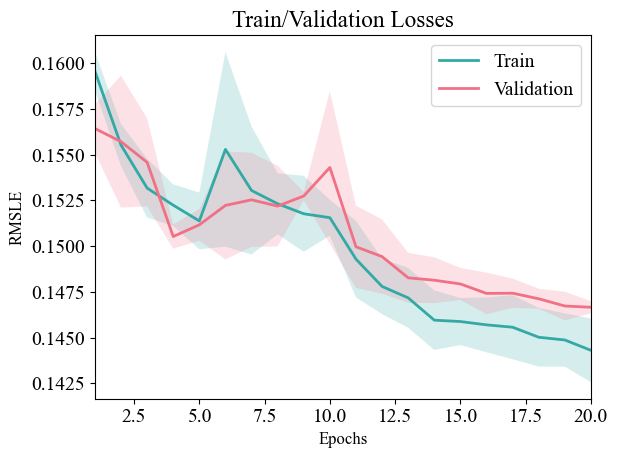

In [23]:
y_label = "RMSLE" if LOG_LOSS else "RMSE"
plot_train_test_losses(train_arr,val_arr, title="Train/Validation Losses", x_label="Epochs", y_label=y_label,
                       min_max_bounds= True, tight_x_lim= True,
                       train_legend = "Train", test_legend = "Validation",
                       save_path=f"results/RUN_{EXP_NAME}_{run_name}_{USER}.png")

In [24]:
import csv

In [25]:
# Format the date and time
now = datetime.now()
finish_string = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Date and Time:", finish_string)

Current Date and Time: 2024-03-26 12:38:13


In [26]:
cv_results["MAE"],cv_results['RMSE'],cv_results["R2"]

([0.15441198962448288, 0.15748178559171894],
 [0.20970340576158822, 0.21330785014442283],
 [0.31611145369327853, 0.2968624342967124])

In [27]:
# Access the values associated with the keys 'MAE' and 'RMSE'
cv_results['MAE']
cv_results['RMSE']


[0.20970340576158822, 0.21330785014442283]

In [28]:
cv_results_full = {}
cv_results_full['MAE_MEAN'] = np.mean(cv_results['MAE'])
cv_results_full['RMSE_MEAN'] = np.mean(cv_results['RMSE'])
cv_results_full['R2_MEAN'] = np.mean(cv_results['R2'])

cv_results_full['MAE_MEAN'],cv_results_full['RMSE_MEAN'],cv_results_full['R2_MEAN']

(0.1559468876081009, 0.21150562795300554, 0.30648694399499543)

In [29]:
cv_results_full['LOAD_SIMCLR_MODEL'] = LOAD_SIMCLR_MODEL
cv_results_full['JUST_LSTM'] = JUST_LSTM
cv_results_full['USE_LSTM_BRANCH'] = USE_LSTM_BRANCH
cv_results_full['USE_PRIM_CLIM'] = USE_PRIM_CLIM
cv_results_full['USE_SEC_CLIM'] = USE_SEC_CLIM
cv_results_full['LOG_LOSS'] = LOG_LOSS
cv_results_full['NUM_CLIMATE_FEATURES'] = NUM_CLIMATE_FEATURES if USE_LSTM_BRANCH else None
cv_results_full['CSV_FILES'] = CSV_FILES if USE_LSTM_BRANCH else None
cv_results_full['NUM_WORKERS'] = NUM_WORKERS
cv_results_full['TRAIN_BATCH_SIZE'] = TRAIN_BATCH_SIZE
cv_results_full['TEST_BATCH_SIZE'] = TEST_BATCH_SIZE
cv_results_full['LEARNING_RATE'] = LEARNING_RATE
cv_results_full['NUM_EPOCHS'] = NUM_EPOCHS
cv_results_full['LR_SCHEDULER'] = LR_SCHEDULER
cv_results_full['CNN_ARCHITECTURE'] = CNN_ARCHITECTURE
cv_results_full['REG_VERSION'] = REG_VERSION
cv_results_full['USE_SPATIAL_ATTENTION'] = USE_SPATIAL_ATTENTION
cv_results_full['Best Seed'] = best_seed
cv_results_full['SEEDS'] = SEEDS
cv_results_full['OC_MAX'] = OC_MAX
cv_results_full['USE_SRTM'] = USE_SRTM
cv_results_full['TIME'] = {"start": start_string, "finish": finish_string}
cv_results_full['cv_results'] = cv_results

In [30]:
with open(f"results/Metrics_{EXP_NAME}_{run_name}_{USER}.json", "w") as fp:
    json.dump(cv_results, fp, indent=4)

In [31]:
# READ JSON FILE
# with open("results/my_dict.json", "r") as fp:
#     my_dict = json.load(fp)

# print(my_dict)

# Analysis

## Save Outputs

In [32]:
# load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
#                 filename='C:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\results\\RUN_D_2023_06_05_T_16_02_Nafiseh.pth.tar') #LSTM 

# load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
#                 filename='C:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\results\\RUN_D_2023_06_03_T_09_41_Nafiseh.pth.tar') #GLAM 

# load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
#                 filename='C:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\results\\RUN_D_2023_06_02_T_20_57_Nafiseh.pth.tar') #Base

# model.eval()
# print("Model loaded")

### Loading the Best Model
Loading the best model from all the coross validation runs.

In [33]:
load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),filename=f"results/RUN_{EXP_NAME}_{run_name}_{USER}_best.pth.tar")

# load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
#                 filename="C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\results\\RUN_D_2024_01_29_T_18_55_Nafiseh.pth.tar")

model.eval()
print("Best Model loaded")

Loading checkpoint=> Done!
Best Model loaded


In [34]:
test_dl_w_id = DataLoader(test_ds_w_id, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [35]:
test_step_w_id(model=model, data_loader=test_dl_w_id, loss_fn=nn.L1Loss(), verbose=False, csv_file=f"results/RUN_{EXP_NAME}_{run_name}_{USER}_best.csv")
print(f"Best model saved to results/RUN_{EXP_NAME}_{run_name}_{USER}_best.csv")
# test_step_w_id(model=model, data_loader=test_dl_w_id, loss_fn=nn.L1Loss(), verbose=False, csv_file=f"results/onlytest_{run_name}_{USER}.csv")

Best model saved to results/RUN_LUCAS_Transformer_NoImage_D_2024_03_26_T_11_42_Nafiseh_best.csv


### Loading the Worst Model
Loading the Worst model from all the coross validation runs.

In [36]:
load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),filename=f"results/RUN_{EXP_NAME}_{run_name}_{USER}_worst.pth.tar")
model.eval()
print("Worst Model loaded")

Loading checkpoint=> Done!
Worst Model loaded


In [37]:
test_step_w_id(model=model, data_loader=test_dl_w_id, loss_fn=nn.L1Loss(), verbose=False, csv_file=f"results/RUN_{EXP_NAME}_{run_name}_{USER}_worst.csv")
print(f"Worst Model saved to results/RUN_{EXP_NAME}_{run_name}_{USER}_worst.csv")

Worst Model saved to results/RUN_LUCAS_Transformer_NoImage_D_2024_03_26_T_11_42_Nafiseh_worst.csv


In [38]:
from importlib import reload
import train_utils
reload(train_utils)
from train_utils import *

In [39]:
df = pd.read_csv(f"results/RUN_{EXP_NAME}_{run_name}_{USER}_best.csv")
# df = pd.read_csv("C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\results\RUN_D_2024_01_29_T_18_55_Nafiseh_best.csv")

y_true = df['y_real']* OC_MAX
y_pred = df['y_pred']* OC_MAX

rmse, r2, rpiq, mae, mec, ccc = evaluate_regression_metrics(y_true, y_pred)

best_dict = {}
best_dict['RMSE'] = rmse
best_dict['R2'] = r2
best_dict['RPIQ'] = rpiq
best_dict['MAE'] = mae
best_dict['MEC'] = mec
best_dict['CCC'] = ccc

print(best_dict)
cv_results_full['best_dict'] = best_dict

{'RMSE': 18.883958346875602, 'R2': 0.4041378963979728, 'RPIQ': 1.4423783839918687, 'MAE': 13.461209548261419, 'MEC': 1.5572464379763862, 'CCC': 0.5740610292489169}


In [40]:
df = pd.read_csv(f"results/RUN_{EXP_NAME}_{run_name}_{USER}_worst.csv")
# df = pd.read_csv("C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\results\RUN_D_2024_01_29_T_18_55_Nafiseh_worst.csv")


y_true = df['y_real']* OC_MAX
y_pred = df['y_pred']* OC_MAX

rmse, r2, rpiq, mae, mec, ccc = evaluate_regression_metrics(y_true, y_pred)

worst_dict = {}
worst_dict['RMSE'] = rmse
worst_dict['R2'] = r2
worst_dict['RPIQ'] = rpiq
worst_dict['MAE'] = mae
worst_dict['MEC'] = mec
worst_dict['CCC'] = ccc

print(worst_dict)
cv_results_full['worst_dict'] = worst_dict

{'RMSE': 19.194416384749967, 'R2': 0.3843845349889258, 'RPIQ': 1.4066159284068729, 'MAE': 13.72876938026048, 'MEC': 1.828046205992425, 'CCC': 0.5456908307183477}


In [41]:
with open(f"results/RUN_{EXP_NAME}_{run_name}_{USER}.json", "w") as fp:
    json.dump(cv_results_full, fp, indent=4)